- [ Прогнозирование заказов такси](#toc1_)    
  - [Подготовка](#toc1_1_)    
  - [Анализ](#toc1_2_)    
  - [Обучение](#toc1_3_)    
    - [Catboost](#toc1_3_1_)    
    - [ TabNet](#toc1_3_2_)    
  - [Тестирование](#toc1_4_)    
  - [Вывод](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[ Прогнозирование заказов такси](#toc0_)

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## <a id='toc1_1_'></a>[Подготовка](#toc0_)

In [1]:
!pip install pytorch-tabnet

In [2]:
!pip install pytorch_optimizer

In [3]:
!pip install category_encoders

In [4]:
import copy
import numpy as np
import random

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import CyclicLR
from pytorch_optimizer import AdaBelief

from category_encoders import TargetEncoder


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_csv('/datasets/taxi.csv')

In [6]:
df.sample(5)

,datetime,num_orders
24382,2018-08-17 07:40:00,13
17033,2018-06-27 06:50:00,0
3096,2018-03-22 12:00:00,6
9205,2018-05-03 22:10:00,9
11768,2018-05-21 17:20:00,21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [8]:
df.duplicated().sum()

0

In [9]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Проблем с пропусками и с дубликатами нет

In [10]:
df['datetime'] = df['datetime'].astype('datetime64')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


## <a id='toc1_2_'></a>[Анализ](#toc0_)

In [12]:
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
df = df.resample('1H').sum()
data = df.copy()

In [13]:
data['rolling_mean'] = data.rolling(10).mean()

<AxesSubplot:xlabel='datetime'>

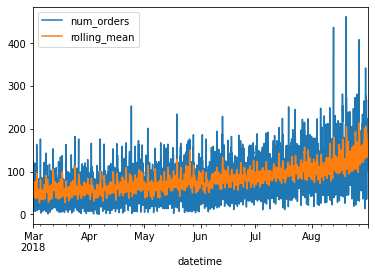

In [14]:
data.plot()

In [15]:
data.dropna(inplace=True)

In [16]:
decomposed = seasonal_decompose(data['num_orders'])

<AxesSubplot:xlabel='datetime'>

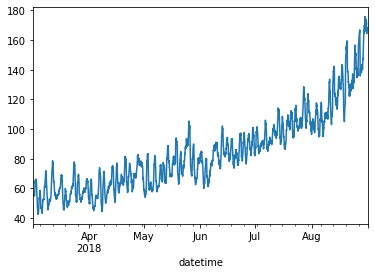

In [17]:
decomposed.trend.plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

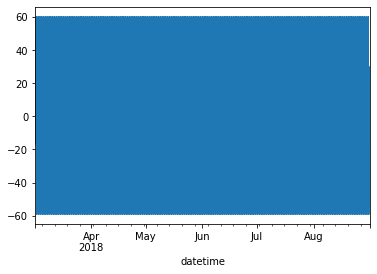

In [18]:
decomposed.seasonal.plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

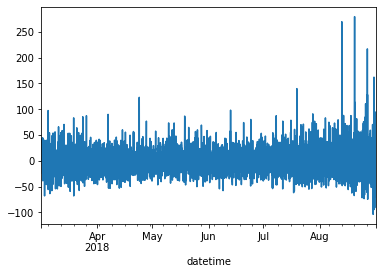

In [19]:
decomposed.resid.plot(ax=plt.gca())

Как видим тренд идет на повышение количества заказов. Сезонность отсутствует.

Перед началом обучения создадим признаки для нашей модели. 

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
make_features(df, 6, 6)

In [22]:
df.dropna(inplace=True)

In [23]:
y = df['num_orders']
X = df.drop('num_orders', axis=1)
df.shape, X.shape, y.shape

((4410, 13), (4410, 12), (4410,))

In [24]:
X.sample(2)

,hour,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-05-17 14:00:00,14,2018,5,17,3,63.0,62.0,92.0,92.0,91.0,61.0,76.833333
2018-07-25 21:00:00,21,2018,7,25,2,111.0,137.0,68.0,121.0,134.0,119.0,115.000000


C учетом неоднородности трафика по дням недели есть смысл представить dayofweek, как категориальный признак. 

In [25]:
X['dayofweek'] = X['dayofweek'].astype('str')
X['hour'] = X['hour'].astype('str')

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4410 entries, 2018-03-01 06:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour          4410 non-null   object 
 1   year          4410 non-null   int64  
 2   month         4410 non-null   int64  
 3   day           4410 non-null   int64  
 4   dayofweek     4410 non-null   object 
 5   lag_1         4410 non-null   float64
 6   lag_2         4410 non-null   float64
 7   lag_3         4410 non-null   float64
 8   lag_4         4410 non-null   float64
 9   lag_5         4410 non-null   float64
 10  lag_6         4410 non-null   float64
 11  rolling_mean  4410 non-null   float64
dtypes: float64(7), int64(3), object(2)
memory usage: 447.9+ KB


## <a id='toc1_3_'></a>[Обучение](#toc0_)

### <a id='toc1_3_1_'></a>[Catboost](#toc0_)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False,
                                                    random_state=4)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3969, 12), (3969,), (441, 12), (441,))

In [29]:
cat = ['dayofweek', 'hour']

ts = TimeSeriesSplit(n_splits=5)

model = CatBoostRegressor(iterations=10000, 
                          cat_features=cat,
                          verbose=False, 
                          eval_metric ='RMSE'
                         )

param = {'l2_leaf_reg':[0.5, 1], 
        'depth':[6, 8], 
         'learning_rate':[0.03, 0.003]
       }

grid_search = model.grid_search(param,
                                X=X_train,
                                y=y_train,
                                train_size=0.8,
                                refit=True,
                                cv=ts,
                                calc_cv_statistics=True,
                                verbose=False,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 30.29545858
bestIteration = 1731


bestTest = 30.22464512
bestIteration = 9986


bestTest = 30.37998059
bestIteration = 1505


bestTest = 30.410447
bestIteration = 9982


bestTest = 30.70822154
bestIteration = 994


bestTest = 30.7625584
bestIteration = 9999


bestTest = 30.89757854
bestIteration = 1262


bestTest = 30.77588186
bestIteration = 9867

Training on fold [0/5]

bestTest = 22.51570131
bestIteration = 1839

Training on fold [1/5]

bestTest = 22.76385794
bestIteration = 9244

Training on fold [2/5]

bestTest = 23.47153278
bestIteration = 9993

Training on fold [3/5]

bestTest = 23.82011453
bestIteration = 3896

Training on fold [4/5]

bestTest = 30.36148048
bestIteration = 7224



In [44]:
best_param = grid_search['params']
print(f'Луший результат: 30.2, со следующими параметрами: {best_param}')

Луший результат: 30.2, со следующими параметрами: {'depth': 6, 'learning_rate': 0.003, 'l2_leaf_reg': 0.5}


### <a id='toc1_3_2_'></a>[ TabNet](#toc0_)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                shuffle=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3528, 12), (3528,), (441, 12), (441,), (441, 12), (441,))

In [32]:
X_train.tail(3)

,hour,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-07-26 03:00:00,3,2018,7,26,3,197.0,73.0,149.0,138.0,84.0,110.0,125.166667
2018-07-26 04:00:00,4,2018,7,26,3,141.0,197.0,73.0,149.0,138.0,84.0,130.333333
2018-07-26 05:00:00,5,2018,7,26,3,131.0,141.0,197.0,73.0,149.0,138.0,138.166667


In [33]:
X_val.tail(3)

,hour,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-08-13 12:00:00,12,2018,8,13,0,144.0,156.0,137.0,91.0,39.0,66.0,105.500000
2018-08-13 13:00:00,13,2018,8,13,0,92.0,144.0,156.0,137.0,91.0,39.0,109.833333
2018-08-13 14:00:00,14,2018,8,13,0,119.0,92.0,144.0,156.0,137.0,91.0,123.166667


In [34]:
X_test.tail(3)

,hour,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-08-31 21:00:00,21,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,171.166667
2018-08-31 22:00:00,22,2018,8,31,4,159.0,154.0,136.0,207.0,217.0,197.0,178.333333
2018-08-31 23:00:00,23,2018,8,31,4,223.0,159.0,154.0,136.0,207.0,217.0,182.666667


In [35]:
X_train.columns

Index(['hour', 'year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'rolling_mean'],
      dtype='object')

In [36]:
cat = ['dayofweek', 'hour']
num = ['year', 'month', 'day', 'lag_1', 'lag_2',
    'lag_3', 'lag_4', 'rolling_mean']

col_transformer_scl = ColumnTransformer(
                    transformers=[
                        ('scal', StandardScaler(), num),
                        ('ohe', TargetEncoder(), cat)
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )


In [37]:
X_train_pre = col_transformer_scl.fit_transform(X_train, y=y_train)
X_val_pre = col_transformer_scl.transform(X_val)
X_test_pre = col_transformer_scl.transform(X_test)

In [38]:
X_train_pre.shape, X_val_pre.shape, X_test_pre.shape

((3528, 10), (441, 10), (441, 10))

In [39]:
unsupervised_model = TabNetPretrainer(  
    n_shared_decoder=1,
    n_indep_decoder=1,
    verbose=20,    
    optimizer_fn=AdaBelief,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax'    
)

unsupervised_model.fit(
    X_train=X_train_pre,
    eval_set=[X_val_pre],
    max_epochs=300 ,
    batch_size=200, virtual_batch_size=128,
    num_workers=0,
    pretraining_ratio=0.5, 
)

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 43.67276| val_0_unsup_loss_numpy: 272.4197998046875|  0:00:01s
epoch 20 | loss: 32.10573| val_0_unsup_loss_numpy: 43.20600128173828|  0:00:32s
epoch 40 | loss: 1.79736 | val_0_unsup_loss_numpy: 32.33143997192383|  0:01:03s
epoch 60 | loss: 0.97763 | val_0_unsup_loss_numpy: 15.244990348815918|  0:01:35s
epoch 80 | loss: 0.79193 | val_0_unsup_loss_numpy: 12.285880088806152|  0:02:11s
epoch 100| loss: 0.73404 | val_0_unsup_loss_numpy: 8.926039695739746|  0:02:44s
epoch 120| loss: 0.71849 | val_0_unsup_loss_numpy: 7.214260101318359|  0:03:18s

Early stopping occurred at epoch 133 with best_epoch = 123 and best_val_0_unsup_loss_numpy = 6.6947197914123535


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [40]:
best_metric = float('inf')
best_model_net = None
for mask_type in ['entmax', 'sparsemax']:
        for gamma in [0.5, 0.7, 0.8, 0.9]:
            model_tab = TabNetRegressor(
                optimizer_fn=AdaBelief,
                optimizer_params=dict(lr=2e-2),
                scheduler_params={"step_size":5,
                                  "gamma":gamma},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                mask_type=mask_type, 
                verbose = 20
            )

            model_tab.fit(
                X_train=X_train_pre, y_train=np.array(y_train).reshape(-1, 1),
                eval_set=[(X_train_pre, np.array(y_train).reshape(-1, 1)), (X_val_pre, np.array(y_val).reshape(-1, 1))],
                eval_name=['train', 'valid'],
                eval_metric=['rmse'],
                max_epochs=200 , patience=30,
                batch_size=200, virtual_batch_size=128,
                num_workers=0,
                drop_last=False,
                from_unsupervised=unsupervised_model, 

            ) 

            predict = model_tab.predict(X_val_pre)
            metric = mean_squared_error(y_val, predict, squared=False)
            print(metric, mask_type, gamma)
            if metric < best_metric:
                best_metric = metric
                best_model_net = copy.deepcopy(model_tab)
                best_param = (mask_type, gamma)
print('Лучшая метрика:', best_metric)
print('Лучшие гиперпараметры:', best_param)

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:01s
epoch 20 | loss: 462.92178| train_rmse: 21.1242 | valid_rmse: 33.32997|  0:00:43s
epoch 40 | loss: 449.14415| train_rmse: 20.65973| valid_rmse: 33.65521|  0:01:25s

Early stopping occurred at epoch 42 with best_epoch = 12 and best_valid_rmse = 32.77984


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


32.779837768908635 entmax 0.5


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:02s
epoch 20 | loss: 449.42837| train_rmse: 20.82577| valid_rmse: 33.38991|  0:00:43s
epoch 40 | loss: 423.51236| train_rmse: 20.00597| valid_rmse: 35.11633|  0:01:24s

Early stopping occurred at epoch 43 with best_epoch = 13 and best_valid_rmse = 32.62835


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


32.628354038645725 entmax 0.7


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:01s
epoch 20 | loss: 446.82455| train_rmse: 20.699  | valid_rmse: 33.65563|  0:00:42s
epoch 40 | loss: 413.27103| train_rmse: 19.70082| valid_rmse: 35.29649|  0:01:23s

Early stopping occurred at epoch 45 with best_epoch = 15 and best_valid_rmse = 32.77804


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


32.77803536223076 entmax 0.8


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:02s
epoch 20 | loss: 450.04835| train_rmse: 20.72732| valid_rmse: 32.60509|  0:00:42s
epoch 40 | loss: 411.18839| train_rmse: 19.4057 | valid_rmse: 31.65423|  0:01:21s

Early stopping occurred at epoch 59 with best_epoch = 29 and best_valid_rmse = 31.19715


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


31.19715298995871 entmax 0.9


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:01s
epoch 20 | loss: 462.92178| train_rmse: 21.1242 | valid_rmse: 33.32997|  0:00:48s
epoch 40 | loss: 449.14415| train_rmse: 20.65973| valid_rmse: 33.65521|  0:01:42s

Early stopping occurred at epoch 42 with best_epoch = 12 and best_valid_rmse = 32.77984


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


32.779837768908635 sparsemax 0.5


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:02s
epoch 20 | loss: 449.42837| train_rmse: 20.82577| valid_rmse: 33.38991|  0:00:54s
epoch 40 | loss: 423.51236| train_rmse: 20.00597| valid_rmse: 35.11633|  0:01:49s

Early stopping occurred at epoch 43 with best_epoch = 13 and best_valid_rmse = 32.62835


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


32.628354038645725 sparsemax 0.7


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:02s
epoch 20 | loss: 446.82455| train_rmse: 20.699  | valid_rmse: 33.65563|  0:01:00s
epoch 40 | loss: 413.27103| train_rmse: 19.70082| valid_rmse: 35.29649|  0:02:26s

Early stopping occurred at epoch 45 with best_epoch = 15 and best_valid_rmse = 32.77804


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


32.77803536223076 sparsemax 0.8


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 6276.41856| train_rmse: 74.96027| valid_rmse: 106.55889|  0:00:03s
epoch 20 | loss: 450.04835| train_rmse: 20.72732| valid_rmse: 32.60509|  0:01:18s
epoch 40 | loss: 411.18839| train_rmse: 19.4057 | valid_rmse: 31.65423|  0:02:25s

Early stopping occurred at epoch 59 with best_epoch = 29 and best_valid_rmse = 31.19715


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


31.19715298995871 sparsemax 0.9
Лучшая метрика: 31.19715298995871
Лучшие гиперпараметры: ('entmax', 0.9)


In [45]:
pd.DataFrame({'model':['Catboost', 'TabNet'], 'RMSE':[30.2 , 31.19]})

,model,RMSE
0,Catboost,30.20
1,TabNet,31.19


На валидационных данных лучше всего себя показала модель Catboost с RMSE 30.2.

## <a id='toc1_4_'></a>[Тестирование](#toc0_)

In [46]:
predict = model.predict(X_test)
metric = mean_squared_error(y_test, predict, squared=False)
metric

39.35338685303478

Значение на тестовой выборке 39.35.

## <a id='toc1_5_'></a>[Вывод](#toc0_)

По результатам анализа работы моделей выбрана модель Catboost, значение RMSE на тестовой выборки данной модели составляет 39.35.

Также анализ данных показал, что имеется тренд на увеличения заказов в час. 